In [1]:
# conda install -c conda-forge gdal
# conda install -c conda-forge geopandas
# conda install -c conda-forge earthpy
# conda install -c conda-forge cloudpathlib
# conda install -c conda-forge pyhdf
# conda install -c anaconda basemap

#conda install -c conda-forge xarray
#conda install -c conda-forge ipywidgets
#conda install -c conda-forge cartopy
## For IO dependencies in xarray 
#conda install -c conda-forge xarray dask netCDF4 bottleneck
#conda install -c conda-forge cfgrib
#conda install -c conda-forge pygrib
#conda install -c yt87 pywgrib2_xr

In [2]:
!jupyter kernelspec list

Available kernels:
  python3    /home/ec2-user/.conda/envs/capstone/share/jupyter/kernels/python3


In [61]:
#Import Packages. 
import sys
import os
import requests
import warnings
import glob

import matplotlib.pyplot as plt
import seaborn as sns
import numpy.ma as ma
#from shapely.geometry import mapping, box
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
from osgeo import gdal
import pandas as pd

#GFS data
import pywgrib2_xr
import pygrib
import xarray # used for reading the data.
import ipywidgets as widgets
import matplotlib.pyplot as plt # used to plot the data.
import ipywidgets as widgets # For ease in selecting variables.
import cartopy.crs as ccrs # Used to georeference data.

#from cloudpathlib import S3Path, S3Client
from pyhdf.SD import SD, SDC

warnings.simplefilter('ignore')

ModuleNotFoundError: No module named 'pywgrib2_xr'

### Downloading GFS Data (0.25 degree)using rdams client

https://github.com/NCAR/rda-apps-clients/blob/main/src/python/rdams_client_example.ipynb

In [60]:
import rdams_client as rc

ModuleNotFoundError: No module named 'rdams_client'

## Old method

In [4]:
 ## First, we need to authenticate
try:
    import getpass
    input = getpass.getpass
except:
    try:
        input = raw_input
    except:
        pass

In [5]:
## Now, we need your password.
pswd = input('password: ')

password:  ···········


In [14]:
values = {'email' : 'jericojohns@berkeley.edu', 'passwd' : pswd, 'action' : 'login'}
login_url = 'https://rda.ucar.edu/cgi-bin/login'

In [7]:
ret = requests.post(login_url, data=values)
if ret.status_code != 200:
    print('Bad Authentication')
    print(ret.text)
    exit(1)

In [8]:
dspath = 'https://rda.ucar.edu/data/ds084.1/'
filelist = ['2015/20150115/gfs.0p25.2015011500.f000.grib2']

In [9]:
save_dir = '/local/train/GFS/'

 #### Now to download the files

In [33]:
for file in filelist:
    filename = dspath + file
    outfile = save_dir + os.path.basename(filename)
    print('Downloading', file)
    req = requests.get(filename, cookies = ret.cookies, allow_redirects=True)
    open(outfile, 'wb').write(req.content)

#### Once you have downloaded the data, the next part can help you plot it.

In order to plot this data, you may need to install librariesIn order to plot this data, you may need to install libraries. The easiest way to do this is to use conda, however any method of getting the following libraries will work.

In [11]:
import xarray # used for reading the data.
import ipywidgets as widgets
import matplotlib.pyplot as plt # used to plot the data.
import ipywidgets as widgets # For ease in selecting variables.
import cartopy.crs as ccrs # Used to georeference data.

In [12]:
filelist_arr = [save_dir + os.path.basename(file) for file in filelist]
selected_file = widgets.Dropdown(options=filelist_arr, description='data file')
display(selected_file)

Dropdown(description='data file', options=('/local/train/GFS/gfs.0p25.2015011500.f000.grib2',), value='/local/…

In [45]:
# Now to load in the data to xarray
ds = xarray.open_dataset(selected_file.value, filter_by_keys={'typeOfLevel': 'planetaryBoundaryLayer'}, engine="cfgrib")

Ignoring index file '/local/train/GFS/gfs.0p25.2015011500.f000.grib2.923a8.idx' incompatible with GRIB file


In [46]:
ds

<xarray.Dataset>
Dimensions:                 (latitude: 721, longitude: 1440)
Coordinates:
    time                    datetime64[ns] ...
    step                    timedelta64[ns] ...
    planetaryBoundaryLayer  float64 ...
  * latitude                (latitude) float64 90.0 89.75 89.5 ... -89.75 -90.0
  * longitude               (longitude) float64 0.0 0.25 0.5 ... 359.5 359.8
    valid_time              datetime64[ns] ...
Data variables:
    u                       (latitude, longitude) float32 ...
    v                       (latitude, longitude) float32 ...
    VRATE                   (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP 
    history:                 2022-02-12T03:49 GRIB to CDM+CF via cfgrib-0.9.1...

In [47]:
# Helper methods# Define function to get standard dimensions
def get_time(dataset):
    for _,cur_coord in dataset.coords.items:
        if cur_coord.attrs['standard_name'] == 'time':
            return cur_coord
def get_lat(dataset):
    for _,cur_coord in dataset.coords.items:
        if cur_coord.attrs['standard_name'] == 'longitude':
            return cur_coord
def get_lon(dataset):
    for _,cur_coord in dataset.coords.items:
        if cur_coord.attrs['standard_name'] == 'latitude':
            return cur_coord

def get_primary(dataset):
    primary_variables = {}
    coords = dataset.coords.keys()
    highest_dims = 0
    for cur_key,cur_var in dataset.variables.items():
        if cur_key not in coords:
            primary_variables[cur_key] = cur_var
    return primary_variables 

In [54]:
ds = get_primary(ds)

ds

{'u': <xarray.Variable (latitude: 721, longitude: 1440)>
 [1038240 values with dtype=float32]
 Attributes:
     GRIB_paramId:                             131
     GRIB_dataType:                            fc
     GRIB_numberOfPoints:                      1038240
     GRIB_typeOfLevel:                         planetaryBoundaryLayer
     GRIB_stepUnits:                           1
     GRIB_stepType:                            instant
     GRIB_gridType:                            regular_ll
     GRIB_NV:                                  0
     GRIB_Nx:                                  1440
     GRIB_Ny:                                  721
     GRIB_cfName:                              eastward_wind
     GRIB_cfVarName:                           u
     GRIB_gridDefinitionDescription:           Latitude/longitude. Also called...
     GRIB_iDirectionIncrementInDegrees:        0.25
     GRIB_iScansNegatively:                    0
     GRIB_jDirectionIncrementInDegrees:        0.25
     GRI

In [17]:
var = widgets.Dropdown(
    options=get_primary(ds).keys(),
    description='Variable')
display(var)

Dropdown(description='Variable', options=('pres', 'icaht', 'gh', 'u', 'v', 't'), value='pres')

In [55]:
var.value
data = ds.values



KeyError: 'pres'

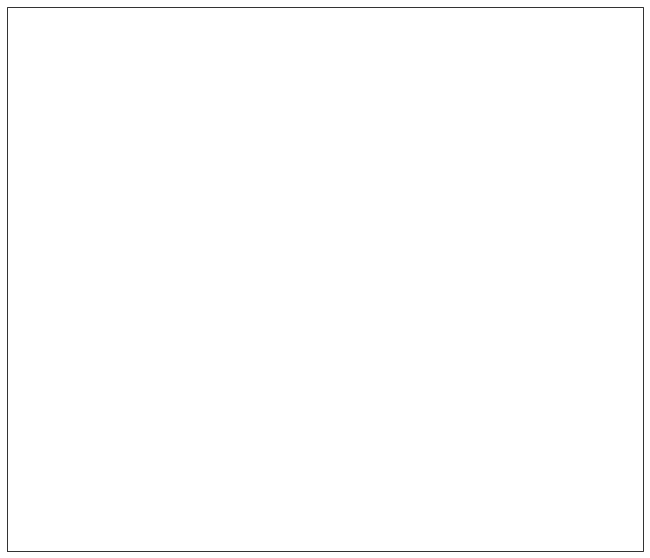

In [58]:
proj = ccrs.Mercator()
plt.gcf().set_size_inches(20,10)
ax = plt.axes(projection=proj)
data_slice = ds[var.value].isel(time=0)
data_slice.plot.contourf(ax=ax, transform=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()

### Downloading MAIAC (MODIS) Data

In [10]:

# s3_cli = S3Client(no_sign_request=True)

# maiac_path = S3Path("s3://drivendata-competition-airathon-public-as/pm25/train/maiac/", client=s3_cli)
# maiac_files = list(maiac_path.rglob("*.hdf"))
# # get first file
# fp = maiac_files[0]
# # download file to temp directory
# fp.fspath
# # download to local
# fp.download_to("1.hdf")

In [15]:
#Open data with gdal
file = gdal.Open('1.hdf')
for path, desc in file.GetSubDatasets():
    print("path:", path, "DESC:", desc)

path: HDF4_EOS:EOS_GRID:"1.hdf":grid1km:Optical_Depth_047 DESC: [4x1200x1200] Optical_Depth_047 grid1km (16-bit integer)
path: HDF4_EOS:EOS_GRID:"1.hdf":grid1km:Optical_Depth_055 DESC: [4x1200x1200] Optical_Depth_055 grid1km (16-bit integer)
path: HDF4_EOS:EOS_GRID:"1.hdf":grid1km:AOD_Uncertainty DESC: [4x1200x1200] AOD_Uncertainty grid1km (16-bit integer)
path: HDF4_EOS:EOS_GRID:"1.hdf":grid1km:FineModeFraction DESC: [4x1200x1200] FineModeFraction grid1km (16-bit integer)
path: HDF4_EOS:EOS_GRID:"1.hdf":grid1km:Column_WV DESC: [4x1200x1200] Column_WV grid1km (16-bit integer)
path: HDF4_EOS:EOS_GRID:"1.hdf":grid1km:AOD_QA DESC: [4x1200x1200] AOD_QA grid1km (16-bit unsigned integer)
path: HDF4_EOS:EOS_GRID:"1.hdf":grid1km:AOD_MODEL DESC: [4x1200x1200] AOD_MODEL grid1km (8-bit unsigned integer)
path: HDF4_EOS:EOS_GRID:"1.hdf":grid1km:Injection_Height DESC: [4x1200x1200] Injection_Height grid1km (32-bit floating-point)
path: HDF4_EOS:EOS_GRID:"1.hdf":grid5km:cosSZA DESC: [4x240x240] cosSZ

In [10]:
def load_data(FILEPATH):
    '''Takes the FILEPATH and loads the SUBDATASET_NAME from that file.'''
    ds = gdal.Open(FILEPATH)
    return ds
    
# Opens the data HDF file and returns as a dataframe
def read_dataset(SUBDATASET_NAME, FILEPATH):
    dataset = load_data(FILEPATH)
    path = ''
    for sub, description in dataset.GetSubDatasets():
        if (description.endswith(SUBDATASET_NAME)):
            path = sub
            break
    if(path == ''):
        print(SUBDATASET_NAME + ' not found')
        return
    subdataset = gdal.Open(path)
    subdataset = subdataset.ReadAsArray()
    subdataset = pd.DataFrame(subdataset)
    return subdataset

In [20]:

maiac_fp = "1.hdf" #path to file here
hdf = SD(maiac_fp, SDC.READ)

# construct grid metadata from text blob
gridmeta = hdf.attributes()["StructMetadata.0"]
gridmeta = dict([x.split("=") for x in gridmeta.split() if "=" in x])

for key, val in gridmeta.items():
    try:
        gridmeta[key] = eval(val)
    except:
        pass

In [21]:
gridmeta

{'GROUP': 'PointStructure',
 'END_GROUP': 'PointStructure',
 'GridName': 'grid5km',
 'XDim': 240,
 'YDim': 240,
 'UpperLeftPointMtrs': (12231455.716333, 3335851.559),
 'LowerRightMtrs': (13343406.236, 2223901.039333),
 'Projection': 'GCTP_SNSOID',
 'ProjParams': (6371007.181, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
 'SphereCode': -1,
 'GridOrigin': 'HDFE_GD_UL',
 'OBJECT': 'DataField_5',
 'DimensionName': 'Orbits',
 'Size': 4,
 'END_OBJECT': 'DataField_5',
 'DataFieldName': 'Glint_Angle',
 'DataType': 'DFNT_INT16',
 'DimList': ('Orbits', 'YDim', 'XDim')}

In [9]:
import os
import re
import pyproj

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from pyhdf.SD import SD, SDC
#from mpl_toolkits.basemap import Basemap

FILE_NAME = '1.hdf'
DATAFIELD_NAME = 'Optical_Depth_055'
hdf = SD(FILE_NAME, SDC.READ)

# Read dataset.
data3D = hdf.select(DATAFIELD_NAME)
data = data3D[0,:,:].astype(np.double)

# Read attributes.
attrs = data3D.attributes(full=1)
lna=attrs["long_name"]
long_name = lna[0]
vra=attrs["valid_range"]
valid_range = vra[0]
fva=attrs["_FillValue"]
_FillValue = fva[0]
sfa=attrs["scale_factor"]
scale_factor = sfa[0]        
ua=attrs["unit"]
units = ua[0]
aoa=attrs["add_offset"]
add_offset = aoa[0]

In [13]:
add_offset

0.0

In [10]:
# Apply the attributes to the data.
invalid = np.logical_or(data < valid_range[0], data > valid_range[1])
invalid = np.logical_or(invalid, data == _FillValue)
data[invalid] = np.nan
data = (data - add_offset) * scale_factor
data = np.ma.masked_array(data, np.isnan(data))

# Construct the grid.  The needed information is in a global attribute
# called 'StructMetadata.0'.  Use regular expressions to tease out the
# extents of the grid.
fattrs = hdf.attributes(full=1)
ga = fattrs["StructMetadata.0"]
gridmeta = ga[0]
ul_regex = re.compile(r'''UpperLeftPointMtrs=\(
                          (?P<upper_left_x>[+-]?\d+\.\d+)
                          ,
                          (?P<upper_left_y>[+-]?\d+\.\d+)
                          \)''', re.VERBOSE)

match = ul_regex.search(gridmeta)
x0 = np.float(match.group('upper_left_x'))
y0 = np.float(match.group('upper_left_y'))

lr_regex = re.compile(r'''LowerRightMtrs=\(
                          (?P<lower_right_x>[+-]?\d+\.\d+)
                          ,
                          (?P<lower_right_y>[+-]?\d+\.\d+)
                          \)''', re.VERBOSE)
match = lr_regex.search(gridmeta)
x1 = np.float(match.group('lower_right_x'))
y1 = np.float(match.group('lower_right_y'))
        
nx, ny = data.shape
x = np.linspace(x0, x1, nx, endpoint=False)
y = np.linspace(y0, y1, ny, endpoint=False)
xv, yv = np.meshgrid(x, y)

sinu = pyproj.Proj("+proj=sinu +R=6371007.181 +nadgrids=@null +wktext")
wgs84 = pyproj.Proj("+init=EPSG:4326") 
lon, lat= pyproj.transform(sinu, wgs84, xv, yv)



/tmp/ipykernel_16943/3154909409.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x0 = np.float(match.group('upper_left_x'))
/tmp/ipykernel_16943/3154909409.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y0 = np.float(match.group('upper_left_y'))
/tmp/ipykernel_16943/3154909409.py:30: DeprecationWarning: `np.float` is a deprecate

In [11]:
lon, lat

(array([[127.01705921, 127.02668171, 127.03630422, ..., 138.53519708,
         138.54481958, 138.55444208],
        [127.00639554, 127.01601724, 127.02563894, ..., 138.52356641,
         138.53318811, 138.54280981],
        [126.99573636, 127.00535725, 127.01497814, ..., 138.51194063,
         138.52156152, 138.53118241],
        ...,
        [117.07815952, 117.08702908, 117.09589863, ..., 127.69501989,
         127.70388945, 127.71275901],
        [117.07195487, 117.08082395, 117.08969304, ..., 127.68825259,
         127.69712168, 127.70599077],
        [117.06575335, 117.07462196, 117.08349058, ..., 127.68148871,
         127.69035732, 127.69922594]]),
 array([[30.        , 30.        , 30.        , ..., 30.        ,
         30.        , 30.        ],
        [29.99166666, 29.99166666, 29.99166666, ..., 29.99166666,
         29.99166666, 29.99166666],
        [29.98333333, 29.98333333, 29.98333333, ..., 29.98333333,
         29.98333333, 29.98333333],
        ...,
        [20.025   

In [14]:
lon.shape

(1200, 1200)